In [35]:
import functools
import gc
import itertools
import os
from itertools import chain

import anndata as ad
import faiss
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import seaborn as sns
from os.path import join
from matplotlib import rcParams
from sklearn.preprocessing import Normalizer
from sklearn.utils.extmath import randomized_svd

import scglue

In [36]:
exp_id = 'MCAsubset-ATLAS'
PATH = f'./cache/{exp_id}'
os.makedirs(PATH, exist_ok=True)

In [37]:
data_root = '/home/yanxh/data/MCA/scjoint/atlas_subset'

rna = sc.read_h5ad(join(data_root, 'adata_rna_raw.h5ad'))
atac = sc.read_h5ad(join(data_root, 'adata_atac_raw.h5ad'))

rna = rna[:, ~rna.var_names.duplicated()].copy()

rna.obs['domain'] = 'RNA'
atac.obs['domain'] = 'ATAC'

# binarizing
# rna.X = (rna.X > 0).astype('float32')

prefix = 'nb_norg_t'

In [4]:
# rename
atac.obs['tissue'] = ['brain' if _.lower() in ['cerebellum', 'prefrontalcortex', 'wholebrain'] else _ for _ in atac.obs.tissue.values]  
atac.obs['tissue'] = ['marrow' if _.lower() in ['bonemarrow'] else _ for _ in atac.obs.tissue.values]

In [5]:
a = rna.obs.tissue.str.lower().unique()

In [6]:
b = atac.obs.tissue.str.lower().unique()

In [7]:
set(a) - set(b), set(b) - set(a)

({'aorta',
  'diaphragm',
  'fat',
  'limb_muscle',
  'mammary_gland',
  'pancreas',
  'trachea'},
 {'smallintestine', 'testes'})

### process feature names

In [8]:
scglue.data.get_gene_annotation(
    rna, gtf="/home/yanxh/data/GLUE_demo/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf",
    gtf_by="gene_name"
)
# exclude NaN rows
rna = rna[:, pd.notna(rna.var["chromStart"])].copy()

split = atac.var_names.str.split(r"[:_]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,chrom,chromStart,chromEnd
chr1_3002478_3002968,chr1,3002478,3002968
chr1_3084739_3085712,chr1,3084739,3085712
chr1_3103576_3104022,chr1,3103576,3104022
chr1_3106871_3107210,chr1,3106871,3107210
chr1_3108932_3109158,chr1,3108932,3109158


### Organ balancing

In [9]:
rna_organ_fracs = rna.obs["tissue"].str.lower().value_counts() / rna.shape[0]
atac_organ_fracs = atac.obs["tissue"].str.lower().value_counts() / atac.shape[0]
cmp_organ_fracs = pd.DataFrame({"rna": rna_organ_fracs, "atac": atac_organ_fracs})

organ_min_fracs = cmp_organ_fracs.min(axis=1)

In [10]:
rs = np.random.RandomState(0)
rna_subidx, atac_subidx = [], []
for organ, min_frac in organ_min_fracs.iteritems():
    print(f"Dealing with {organ}...")
    rna_idx = np.where(rna.obs["tissue"].str.lower() == organ)[0]
    atac_idx = np.where(atac.obs["tissue"].str.lower() == organ)[0]
    
    if (len(rna_idx) == 0) or (len(atac_idx) == 0): 
        print('\t ignore')
        continue
        
    rna_subidx.append(rs.choice(rna_idx, max(1, round(min_frac * rna.shape[0])), replace=False))
    atac_subidx.append(rs.choice(atac_idx, max(1, round(min_frac * atac.shape[0])), replace=False))
rna_subidx = np.concatenate(rna_subidx)
rna_mask = np.zeros(rna.shape[0], dtype=bool)
rna_mask[rna_subidx] = True
rna.obs["mask"] = rna_mask
atac_subidx = np.concatenate(atac_subidx)
atac_mask = np.zeros(atac.shape[0], dtype=bool)
atac_mask[atac_subidx] = True
atac.obs["mask"] = atac_mask

/tmp/ipykernel_19862/3542238783.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for organ, min_frac in organ_min_fracs.iteritems():


Dealing with aorta...
	 ignore
Dealing with brain...
Dealing with diaphragm...
	 ignore
Dealing with fat...
	 ignore
Dealing with heart...
Dealing with kidney...
Dealing with largeintestine...
Dealing with limb_muscle...
	 ignore
Dealing with liver...
Dealing with lung...
Dealing with mammary_gland...
	 ignore
Dealing with marrow...
Dealing with pancreas...
	 ignore
Dealing with smallintestine...
	 ignore
Dealing with spleen...
Dealing with testes...
	 ignore
Dealing with thymus...
Dealing with trachea...
	 ignore


In [11]:
rna_organ_balancing = np.sqrt(cmp_organ_fracs["atac"] / cmp_organ_fracs["rna"])
atac_organ_balancing = np.sqrt(cmp_organ_fracs["rna"] / cmp_organ_fracs["atac"])

rna_organ_balancing = rna_organ_balancing.fillna(1)
atac_organ_balancing = atac_organ_balancing.fillna(1)

In [12]:
rna.obs["organ_balancing"] = rna_organ_balancing.loc[rna.obs["tissue"].str.lower()].to_numpy()
atac.obs["organ_balancing"] = atac_organ_balancing.loc[atac.obs["tissue"].str.lower()].to_numpy()

### Gene selection and Dimreduction

In [13]:
hvg_df = sc.pp.highly_variable_genes(rna[rna.obs["mask"], :], n_top_genes=4000, flavor="seurat_v3", inplace=False)
rna.var = rna.var.assign(**hvg_df.to_dict(orient="series"))

In [14]:
rna.layers["raw_counts"] = rna.X.copy()
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
rna = rna[:, rna.var.highly_variable].copy()
gc.collect()

681

In [15]:
X = sps.csr_matrix(rna.X)
X_masked = X[rna.obs["mask"]]
mean = X_masked.mean(axis=0).A1
std = np.sqrt(X_masked.power(2).mean(axis=0).A1 - mean ** 2)
X = X.toarray()
X -= mean
X /= std
X = X.clip(-10, 10)
X_masked = X[rna.obs["mask"]]

In [16]:
u, s, vh = randomized_svd(X_masked.T @ X_masked, 100, n_iter=15, random_state=0)
rna.obsm["X_pca"] = X @ vh.T

In [17]:
rna.X = rna.layers["raw_counts"]
del rna.layers["raw_counts"], X, X_masked, mean, std, u, s, vh
gc.collect()

0

In [18]:
X = scglue.num.tfidf(atac.X)
X = Normalizer(norm="l1").fit_transform(X)
X = np.log1p(X * 1e4)
X_masked = X[atac.obs["mask"]]
u, s, vh = randomized_svd(X_masked, 100, n_iter=15, random_state=0)
X_lsi = X @ vh.T / s
X_lsi -= X_lsi.mean(axis=1, keepdims=True)
X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)

atac.obsm["X_lsi"] = X_lsi.astype(np.float32)

del X, X_masked, X_lsi, u, s, vh
gc.collect()

# np.save(f'{PATH}/x_lsi.npy', atac.obsm["X_lsi"])
# X_lsi = np.load(f'{PATH}/x_lsi.npy')
# atac.obsm["X_lsi"] = X_lsi.astype(np.float32)

### Creat graph

generate hvg for atac

In [19]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
scglue.graph.check_graph(guidance, [rna, atac])

window_graph: 100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1467.22it/s]


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


# 2. scGLUE Pretrain

In [20]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_rep="X_pca",        # 和tutorial不同的是这里layer是默认的，前面用raw_count替换了X
    use_dsc_weight="organ_balancing",
#     use_cell_type='cell_type'
)

In [21]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi",
    use_dsc_weight="organ_balancing"
)

In [22]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

# nx.write_graphml(guidance, f"{PATH}/full.graphml.gz")
# nx.write_graphml(guidance_hvf, f"{PATH}/sub.graphml.gz")

# graph = nx.read_graphml(f"{PATH}/full.graphml.gz")
# subgraph = nx.read_graphml(f"{PATH}/sub.graphml.gz")

In [23]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": PATH}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 1 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 47291
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "cache/MCAsubset-ATLAS/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.413, 'g_kl': 0.003, 'g_elbo': 0.416, 'x_rna_nll': 0.565, 'x_rna_kl': 0.009, 'x_rna_elbo': 0.574, 'x_atac_nll': 0.053, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.054, 'dsc_loss': 0.691, 'vae_loss': 0.645, 'gen_loss': 0.61}, val={'g_nll': 0.413, 'g_kl': 0.003, 'g_elbo': 0.416, 'x_rna_nll': 0.571, 'x_rna_kl': 0.008, 'x_rna_elbo': 0.579, 'x_atac_nll': 0.054, 'x_atac_kl': 0.001, 'x_atac_elb

2023-02-07 17:53:56,205 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "21"...
[INFO] EarlyStopping: Restoring checkpoint "21"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (31, 27)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 47291
[INFO] SCGLUEModel: Setting `align_burnin` = 8
[INFO] SCGLUEModel: Setting `max_epochs` = 48
[INFO] SCGLUEModel: Setting `patience` = 4
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] SCGLUETrainer: Using training directory: "cache/MCAsubset-ATLAS/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.407, 'g_kl': 0.003, 'g_elbo': 0.41, 'x_rna_nll': 0.555, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.562, 'x_atac_nll': 0.053, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.053, 'dsc_loss': 0.682, 'vae_loss': 0.631, 'gen

2023-02-07 18:07:34,394 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "20"...
[INFO] EarlyStopping: Restoring checkpoint "20"...


In [22]:
# glue.save(f"{PATH}/glue.dill")
glue = scglue.models.load_model(f"{PATH}/glue_.5083.dill")

[INFO] autodevice: Using GPU 1 as computation device.


# Label transfer

In [23]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [24]:
atac.obs['cell_type_bkp'] = atac.obs['cell_type'].values 
atac.obs = atac.obs.drop(columns=['cell_type'])

In [25]:
scglue.data.transfer_labels(rna, atac, "cell_type", use_rep="X_glue")

In [27]:
(atac.obs.cell_type == atac.obs.cell_type_bkp).mean()

0.5082605145666487

# Vis

In [28]:
import umap
def umap_reduce(ad_smp, x_emb='raw'):
    reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
    embedding = reducer.fit_transform(ad_smp.X if x_emb=='raw' else ad_smp.obsm[x_emb])
    ad_smp.obsm["X_umap"] = embedding
    return ad_smp

In [29]:
atac = umap_reduce(atac, 'X_glue')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/yanxh/anaconda3/envs/scglue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


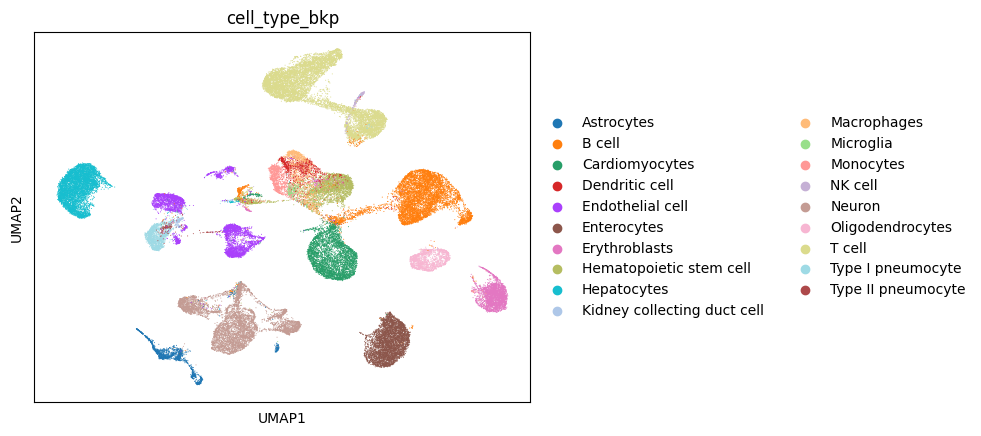

In [31]:
sc.pl.umap(atac, color='cell_type_bkp')